Mean faces
Eigenfaces
Testing accuracy (single eigenface)
EER (test, single eigenface) = 0.20499999999999996
Training accuracy (single eigenface)
EER (train, single eigenface) = 0.21499999999999986
Generating training coefficients
Eigenvectors 1, Correct 1NN 43/200 (0.21)
Eigenvectors 2, Correct 1NN 174/200 (0.87)
Eigenvectors 3, Correct 1NN 180/200 (0.90)
Eigenvectors 4, Correct 1NN 177/200 (0.89)
Eigenvectors 5, Correct 1NN 177/200 (0.89)
Eigenvectors 6, Correct 1NN 172/200 (0.86)
Eigenvectors 7, Correct 1NN 178/200 (0.89)
Eigenvectors 8, Correct 1NN 176/200 (0.88)
Fisherfaces
Testing accuracy (single fisherface)
EER (fisher test) = 0.10999999999999993
Training accuracy (fisherface)
EER (fisher train) = 0.0


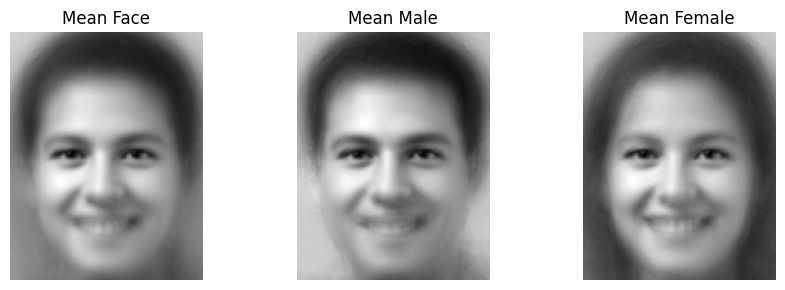

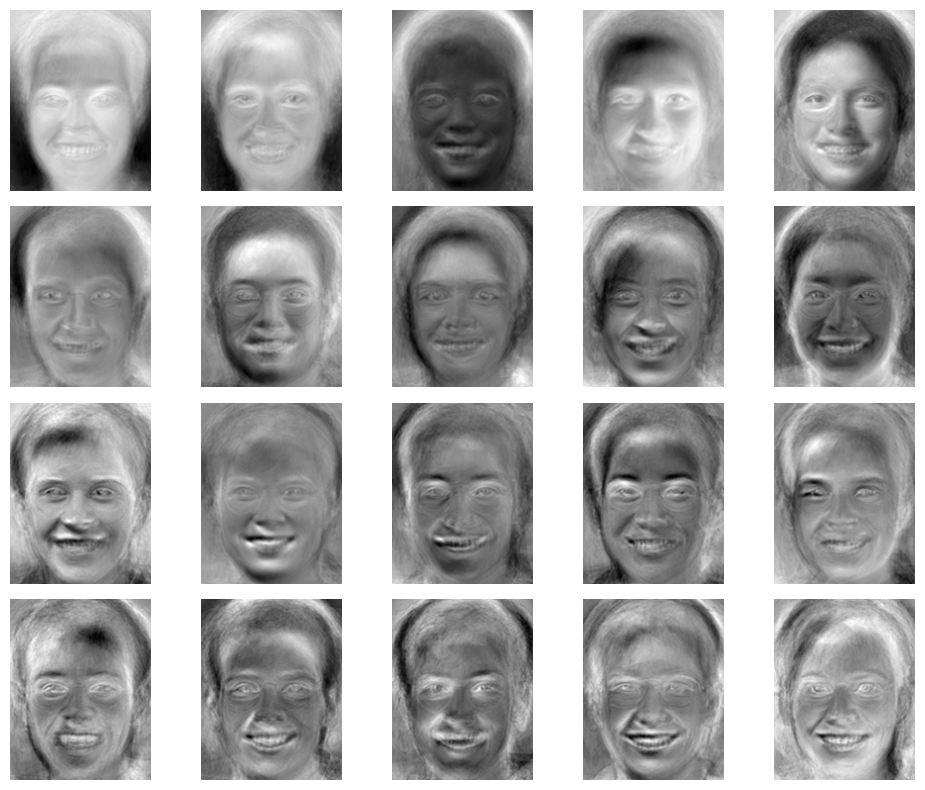

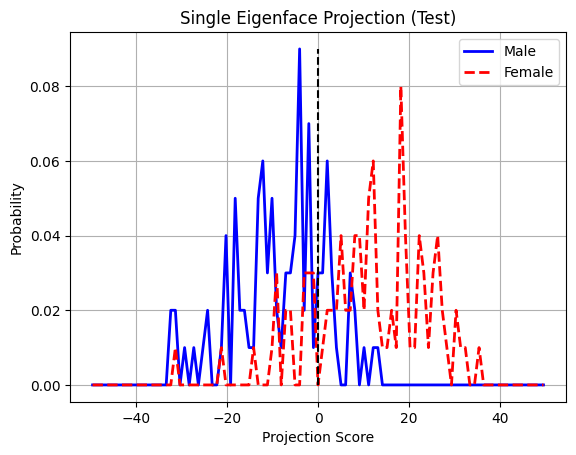

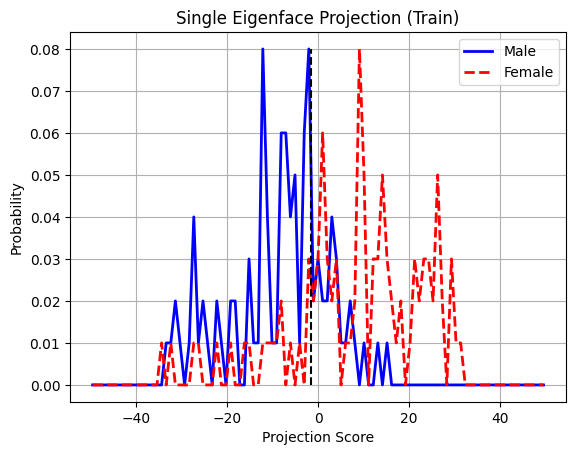

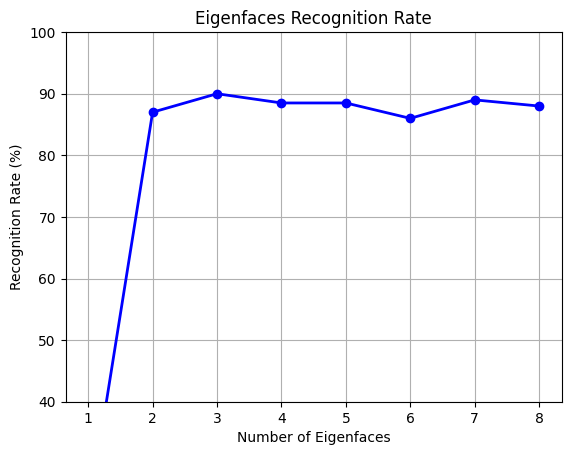

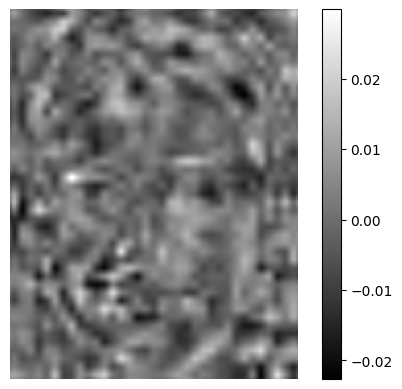

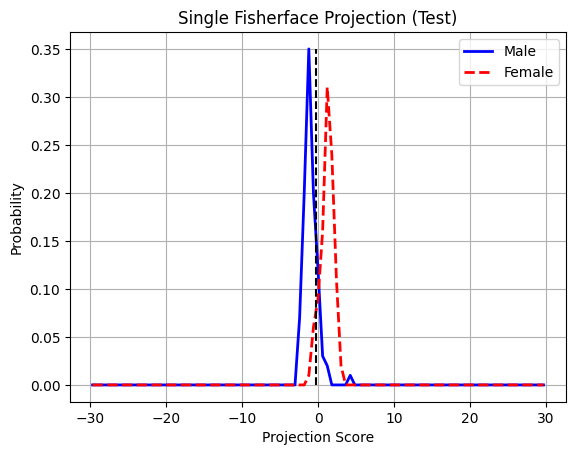

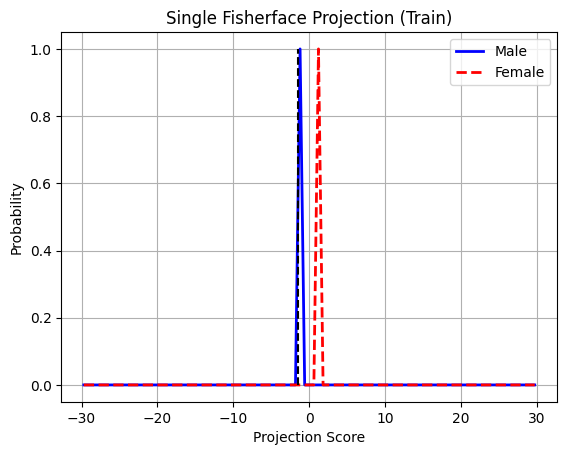

In [1]:
"""
Gender recognition using eigenfaces and fisherfaces
Translated from MATLAB -> Python

Dependencies:
 numpy, scipy, matplotlib, scikit-image, pillow, imageio
"""

import os
import numpy as np
import imageio
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.linalg import eigh
from scipy.sparse.linalg import eigs
from numpy.linalg import norm

# ---------- Helper functions ----------
def list_dir(folder, ext=".jpg"):
    files = [os.path.join(folder, f) for f in sorted(os.listdir(folder))
             if f.lower().endswith(ext)]
    return files

def im2double(img):
    # convert image (PIL or numpy) to float in [0,1]
    arr = np.asarray(img).astype(np.float64)
    if arr.max() > 1.0:
        arr /= 255.0
    return arr

def im2vec(img):
    return img.flatten()[:, None]  # column vector

def clip_matrix(M, eps=1e-6):
    # Ensure matrix is symmetric positive definite-ish for eigs
    M = (M + M.T) / 2.0
    # small regularization
    return M + eps * np.eye(M.shape[0])

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)

# ---------- Config ----------
align_label = '_aligned'
# align_label = ''
align_crop_y = slice(11, 191)   # MATLAB 11:190 -> Python slice(11,191)
align_crop_x = slice(34, 174)   # MATLAB 34:173 -> Python slice(34,174)
normalize_std = False
target_std = 0.3
data_folders = [os.path.join('Data' + align_label, 'Male'),
                os.path.join('Data' + align_label, 'Female')]
ensure_dir('Results')

# ---------- Load image file lists ----------
image_files = [list_dir(d, '.jpg') for d in data_folders]
if len(image_files[0]) == 0 or len(image_files[1]) == 0:
    raise RuntimeError("No images found. Check Data folders and alignment label.")

# MATLAB used 1:2:end (1-based) for training on class1, and 2:2:end for testing from class2
training_indices = list(range(0, len(image_files[0]), 2))   # 0,2,4,...
testing_indices = list(range(1, len(image_files[1]), 2))    # 1,3,5,...

# ---------- Compute mean faces ----------
print("Mean faces")
mean_faces = [None, None]
mean_samples = [training_indices, training_indices]  # as in original

for n_class in range(2):
    num_samples = 0
    acc = None
    for n_image in mean_samples[n_class]:
        image_file = image_files[n_class][n_image]
        img = im2double(Image.open(image_file).convert('L'))
        if align_label == '_aligned':
            img = img[align_crop_y, align_crop_x]
        if normalize_std:
            img = img * (target_std / np.std(img))
        if acc is None:
            acc = np.copy(img)
        else:
            acc = acc + img
        num_samples += 1
    mean_faces[n_class] = acc / num_samples

mean_face = 0.5 * (mean_faces[0] + mean_faces[1])

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(mean_face, cmap='gray'); plt.title('Mean Face')
plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mean_faces[0], cmap='gray'); plt.title('Mean Male')
plt.axis('off')
plt.subplot(1,3,3); plt.imshow(mean_faces[1], cmap='gray'); plt.title('Mean Female')
plt.axis('off')
plt.tight_layout()
imageio.imwrite('Results/mean_face_1.jpg', (mean_faces[0]*255).astype(np.uint8))
imageio.imwrite('Results/mean_face_2.jpg', (mean_faces[1]*255).astype(np.uint8))
imageio.imwrite('Results/mean_face.jpg', (mean_face*255).astype(np.uint8))

img_size = mean_face.shape

# ---------- Compute eigenfaces ----------
print("Eigenfaces")
S_list = []
for n_class in range(2):
    for n_image in training_indices:
        image_file = image_files[n_class][n_image]
        img = im2double(Image.open(image_file).convert('L'))
        if align_label == '_aligned':
            img = img[align_crop_y, align_crop_x]
        if normalize_std:
            img = img * (target_std / np.std(img))
        img_zero = img - mean_face
        S_list.append(im2vec(img_zero))

# Build matrix S where each column is vectorized zero-mean image
S = np.hstack(S_list)  # shape (num_pixels, num_samples)
# Compute eigen decomposition of small matrix S^T S
K = S.shape[1]
# S^T S is KxK
StS = S.T @ S
# Use eigh (symmetric) and sort descending
eigvals, eigvecs = eigh(StS)
eigvecs = eigvecs[:, ::-1]  # reverse order (largest first)
eigenfaces = S @ eigvecs
# normalize eigenfaces
for n in range(eigenfaces.shape[1]):
    eigenfaces[:, n] /= norm(eigenfaces[:, n]) + 1e-12

# Show first 20 eigenfaces
plt.figure(figsize=(10,8))
for n in range(min(20, eigenfaces.shape[1])):
    plt.subplot(4,5,n+1)
    ef = eigenfaces[:, n].reshape(img_size)
    plt.imshow(ef, cmap='gray', vmin=ef.min(), vmax=ef.max())
    plt.axis('off')
    # save normalized for display
    mn, mx = ef.min(), ef.max()
    rng = mx - mn if mx > mn else 1.0
    imageio.imwrite(f"Results/eigenface_{n+1:02d}.jpg", ((ef - mn)/rng*255).astype(np.uint8))
plt.tight_layout()

# ---------- Compute recognition scores for single eigenface ----------
print("Testing accuracy (single eigenface)")
eigenface_img = eigenfaces[:, 0].reshape(img_size)
scores = [[], []]

for n_class in range(2):
    for n_image in testing_indices:
        # beware: testing_indices was derived from class 2 in original; follow same behavior
        # if class lengths differ this mirrors original script behavior
        image_file = image_files[n_class][n_image]
        img = im2double(Image.open(image_file).convert('L'))
        if align_label == '_aligned':
            img = img[align_crop_y, align_crop_x]
        if normalize_std:
            img = img * (target_std / np.std(img))
        img_zero = img - mean_face
        scores[n_class].append(np.sum(img_zero * eigenface_img))

scores = [np.array(s) for s in scores]

hist_bins = np.linspace(-50, 50, 100)
hist_male, _ = np.histogram(scores[0], bins=hist_bins)
hist_female, _ = np.histogram(scores[1], bins=hist_bins)
pmf_male = hist_male / hist_male.sum()
pmf_female = hist_female / hist_female.sum()
cdf_male = np.cumsum(pmf_male)
cdf_female = np.cumsum(pmf_female)

# find index minimizing abs(1 - cdfFemale - cdfMale)
abs_diffs = np.abs(1.0 - cdf_female - cdf_male)
min_idx = np.argmin(abs_diffs)
eigenface_threshold = (hist_bins[min_idx] + hist_bins[min_idx+1]) / 2.0
EER = 0.5 * (cdf_male[min_idx] + 1 - cdf_female[min_idx])
# flip if mean of pmfMale < pmfFemale as in original
if np.dot(pmf_male, hist_bins[:-1]) < np.dot(pmf_female, hist_bins[:-1]):
    EER = 1.0 - EER
print("EER (test, single eigenface) =", EER)

plt.figure()
centers = (hist_bins[:-1] + hist_bins[1:]) / 2.0
plt.plot(centers, pmf_male, 'b-', linewidth=2)
plt.plot(centers, pmf_female, 'r--', linewidth=2)
plt.plot([eigenface_threshold, eigenface_threshold], [0, max(pmf_male.max(), pmf_female.max())], 'k--')
plt.xlabel('Projection Score'); plt.ylabel('Probability'); plt.legend(['Male','Female'])
plt.title('Single Eigenface Projection (Test)')
plt.grid(True)

# ---------- Training accuracy (single eigenface) ----------
print("Training accuracy (single eigenface)")
scores_train = [[], []]
for n_class in range(2):
    for n_image in training_indices:
        image_file = image_files[n_class][n_image]
        img = im2double(Image.open(image_file).convert('L'))
        if align_label == '_aligned':
            img = img[align_crop_y, align_crop_x]
        if normalize_std:
            img = img * (target_std / np.std(img))
        img_zero = img - mean_face
        scores_train[n_class].append(np.sum(img_zero * eigenface_img))
scores_train = [np.array(s) for s in scores_train]

hist_male, _ = np.histogram(scores_train[0], bins=hist_bins)
hist_female, _ = np.histogram(scores_train[1], bins=hist_bins)
pmf_male = hist_male / hist_male.sum()
pmf_female = hist_female / hist_female.sum()
cdf_male = np.cumsum(pmf_male)
cdf_female = np.cumsum(pmf_female)
abs_diffs = np.abs(1.0 - cdf_female - cdf_male)
min_idx = np.argmin(abs_diffs)
EER = 0.5 * (cdf_male[min_idx] + 1 - cdf_female[min_idx])
if np.dot(pmf_male, hist_bins[:-1]) < np.dot(pmf_female, hist_bins[:-1]):
    EER = 1.0 - EER
print("EER (train, single eigenface) =", EER)

plt.figure()
plt.plot(centers, pmf_male, 'b-', linewidth=2)
plt.plot(centers, pmf_female, 'r--', linewidth=2)
plt.plot([hist_bins[min_idx], hist_bins[min_idx]], [0, max(pmf_male.max(), pmf_female.max())], 'k--')
plt.xlabel('Projection Score'); plt.ylabel('Probability'); plt.legend(['Male','Female'])
plt.title('Single Eigenface Projection (Train)')
plt.grid(True)

# ---------- Multiple eigenfaces: build training coefficients ----------
print("Generating training coefficients")
num_eigenfaces = eigenfaces.shape[1]
training_coeff = [np.zeros((num_eigenfaces, 0)), np.zeros((num_eigenfaces, 0))]
for n_class in range(2):
    cols = []
    for n_image in training_indices:
        image_file = image_files[n_class][n_image]
        img = im2double(Image.open(image_file).convert('L'))
        if align_label == '_aligned':
            img = img[align_crop_y, align_crop_x]
        if normalize_std:
            img = img * (target_std / np.std(img))
        img_zero = img - mean_face
        coeff = np.array([np.dot(img_zero.flatten(), eigenfaces[:, i]) for i in range(num_eigenfaces)])
        cols.append(coeff[:, None])
    if len(cols) > 0:
        training_coeff[n_class] = np.hstack(cols)
    else:
        training_coeff[n_class] = np.zeros((num_eigenfaces, 0))

# ---------- Recognition over number of eigenfaces ----------
num_eig_vec = list(range(1, min(8, num_eigenfaces) + 1))
accuracies_1nn = []

for num_eig in num_eig_vec:
    num_correct_1nn = 0
    num_queried = 0
    for n_class in range(2):
        for n_image in testing_indices:
            image_file = image_files[n_class][n_image]
            img = im2double(Image.open(image_file).convert('L'))
            if align_label == '_aligned':
                img = img[align_crop_y, align_crop_x]
            if normalize_std:
                img = img * (target_std / np.std(img))
            img_zero = img - mean_face
            coeff = np.array([np.dot(img_zero.flatten(), eigenfaces[:, i]) for i in range(num_eigenfaces)])
            # compute distances to all training samples
            distances = []
            labels = []
            for other_class in range(2):
                for s_idx in range(training_coeff[other_class].shape[1]):
                    v1 = coeff[:num_eig]
                    v2 = training_coeff[other_class][:num_eig, s_idx]
                    distances.append(np.linalg.norm(v1 - v2))
                    labels.append(other_class + 1)  # label 1 or 2 as in MATLAB
            distances = np.array(distances)
            sort_idx = np.argsort(distances)
            num_queried += 1
            if num_eig == 1:
                if coeff[0] > eigenface_threshold:
                    label_1nn = 1
                else:
                    label_1nn = 2
            else:
                label_1nn = labels[sort_idx[0]]
            if label_1nn == (n_class + 1):
                num_correct_1nn += 1
    acc = num_correct_1nn / num_queried if num_queried > 0 else 0.0
    print(f"Eigenvectors {num_eig}, Correct 1NN {num_correct_1nn}/{num_queried} ({acc:.2f})")
    accuracies_1nn.append(acc)

plt.figure()
plt.plot(num_eig_vec, np.array(accuracies_1nn)*100, 'b-o', linewidth=2)
plt.grid(True)
plt.xlabel('Number of Eigenfaces'); plt.ylabel('Recognition Rate (%)')
plt.ylim(40, 100)
plt.title('Eigenfaces Recognition Rate')

# ---------- Fisherfaces ----------
print("Fisherfaces")
ds = 0.25
# compute delta means at downsample factor
mean1_ds = resize(mean_faces[0], (int(img_size[0]*ds), int(img_size[1]*ds)), anti_aliasing=True)
mean_all_ds = resize(mean_face, (int(img_size[0]*ds), int(img_size[1]*ds)), anti_aliasing=True)
delta_mean1 = im2vec(mean1_ds - mean_all_ds)
RB = len(image_files[0]) * (delta_mean1 @ delta_mean1.T)

mean2_ds = resize(mean_faces[1], (int(img_size[0]*ds), int(img_size[1]*ds)), anti_aliasing=True)
delta_mean2 = im2vec(mean2_ds - mean_all_ds)
RB = RB + len(image_files[1]) * (delta_mean2 @ delta_mean2.T)

RW = np.zeros_like(RB)
for n_class in range(2):
    for n_image in training_indices:
        image_file = image_files[n_class][n_image]
        img = im2double(Image.open(image_file).convert('L'))
        if align_label == '_aligned':
            img = img[align_crop_y, align_crop_x]
        if normalize_std:
            img = img * (target_std / np.std(img))
        # in original script imgZeroMean = img (not subtract meanFace)
        delta = im2vec(resize(img - mean_faces[n_class], (int(img_size[0]*ds), int(img_size[1]*ds)), anti_aliasing=True))
        RW = RW + (delta @ delta.T)

RW = clip_matrix(RW)
# Solve generalized eigenproblem RB v = lambda RW v
# Use eigs to get the top eigenvector
try:
    vals, vecs = eigs(RB, k=1, M=RW, which='LM')
    fisherfaces = vecs[:, 0].real
except Exception as e:
    # fallback to dense generalized eigendecomposition (small matrices)
    vals_all, vecs_all = eigh(RB, RW)
    idx = np.argsort(vals_all)[::-1]
    fisherfaces = vecs_all[:, idx[0]]

fisherfaces = fisherfaces / (norm(fisherfaces) + 1e-12)

# display fisherface
fisherface = fisherfaces.reshape((int(img_size[0]*ds), int(img_size[1]*ds)))
fisherface_up = resize(fisherface, img_size, anti_aliasing=True)
fisherface_up = fisherface_up / (norm(fisherface_up.flatten()) + 1e-12)
plt.figure()
plt.imshow(fisherface_up, cmap='gray')
plt.colorbar()
plt.axis('off')
mn, mx = fisherface_up.min(), fisherface_up.max()
rng = mx - mn if mx > mn else 1.0
imageio.imwrite('Results/fisherface_01.jpg', ((fisherface_up - mn)/rng*255).astype(np.uint8))

# save fisherface array
np.save('Results/fisherface.npy', fisherface_up)

# ---------- Recognition using single Fisherface ----------
print("Testing accuracy (single fisherface)")
scores_f = [[], []]
fisherface_for_proj = fisherface_up  # same as MATLAB: resized back to original size

for n_class in range(2):
    for n_image in testing_indices:
        image_file = image_files[n_class][n_image]
        img = im2double(Image.open(image_file).convert('L'))
        if align_label == '_aligned':
            img = img[align_crop_y, align_crop_x]
        if normalize_std:
            img = img * (target_std / np.std(img))
        img_zero = img - mean_face
        scores_f[n_class].append(np.sum(img_zero * fisherface_for_proj))

scores_f = [np.array(s) for s in scores_f]
hist_bins_f = np.linspace(-30, 30, 100)
hist_male_f, _ = np.histogram(scores_f[0], bins=hist_bins_f)
hist_female_f, _ = np.histogram(scores_f[1], bins=hist_bins_f)
pmf_male_f = hist_male_f / hist_male_f.sum() if hist_male_f.sum() > 0 else hist_male_f
pmf_female_f = hist_female_f / hist_female_f.sum() if hist_female_f.sum() > 0 else hist_female_f
cdf_male_f = np.cumsum(pmf_male_f)
cdf_female_f = np.cumsum(pmf_female_f)
abs_diffs_f = np.abs(1.0 - cdf_male_f - cdf_female_f)
min_idx_f = np.argmin(abs_diffs_f)
EER_f = 0.5 * (cdf_female_f[min_idx_f] + 1 - cdf_male_f[min_idx_f])
print("EER (fisher test) =", EER_f)

plt.figure()
centers_f = (hist_bins_f[:-1] + hist_bins_f[1:]) / 2.0
plt.plot(centers_f, pmf_male_f, 'b-', linewidth=2)
plt.plot(centers_f, pmf_female_f, 'r--', linewidth=2)
plt.plot([hist_bins_f[min_idx_f], hist_bins_f[min_idx_f]], [0, max(pmf_male_f.max(), pmf_female_f.max())], 'k--')
plt.xlabel('Projection Score'); plt.ylabel('Probability'); plt.legend(['Male','Female'])
plt.title('Single Fisherface Projection (Test)')
plt.grid(True)

# ---------- Training accuracy for fisherface ----------
print("Training accuracy (fisherface)")
scores_f_train = [[], []]
for n_class in range(2):
    for n_image in training_indices:
        image_file = image_files[n_class][n_image]
        img = im2double(Image.open(image_file).convert('L'))
        if align_label == '_aligned':
            img = img[align_crop_y, align_crop_x]
        if normalize_std:
            img = img * (target_std / np.std(img))
        img_zero = img - mean_face
        scores_f_train[n_class].append(np.sum(img_zero * fisherface_for_proj))

scores_f_train = [np.array(s) for s in scores_f_train]
hist_male_f, _ = np.histogram(scores_f_train[0], bins=hist_bins_f)
hist_female_f, _ = np.histogram(scores_f_train[1], bins=hist_bins_f)
pmf_male_f = hist_male_f / hist_male_f.sum() if hist_male_f.sum() > 0 else hist_male_f
pmf_female_f = hist_female_f / hist_female_f.sum() if hist_female_f.sum() > 0 else hist_female_f
cdf_male_f = np.cumsum(pmf_male_f)
cdf_female_f = np.cumsum(pmf_female_f)
abs_diffs_f = np.abs(1.0 - cdf_male_f - cdf_female_f)
min_idx_f = np.argmin(abs_diffs_f)
EER_f_train = 0.5 * (cdf_female_f[min_idx_f] + 1 - cdf_male_f[min_idx_f])
print("EER (fisher train) =", EER_f_train)

plt.figure()
plt.plot(centers_f, pmf_male_f, 'b-', linewidth=2)
plt.plot(centers_f, pmf_female_f, 'r--', linewidth=2)
plt.plot([hist_bins_f[min_idx_f], hist_bins_f[min_idx_f]], [0, max(pmf_male_f.max(), pmf_female_f.max())], 'k--')
plt.xlabel('Projection Score'); plt.ylabel('Probability'); plt.legend(['Male','Female'])
plt.title('Single Fisherface Projection (Train)')
plt.grid(True)

plt.show()
